### Human_Activity_Analysis_20231031

#### Process
1. 데이터탐색
 - 특성추출 (8개) *특성이 개수를 보고 차원축소는 하지 않기로 함
2. 모델찾기 및 튜닝
 - pycaret compare.models() 
 3. 성능 평가
 - train vs test 
 4. 시각화

#### 1.데이터 탐색 (특성 추출하기)

In [9]:
# 필요한 라이브러리를 임포트합니다.
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import pandas as pd

# CSV 파일에서 데이터를 불러옵니다.
train_data = pd.read_csv('train.csv')
print(train_data.shape)
y_train = train_data['activity']
X_train = train_data.drop('activity', axis=1)

# 랜덤 포레스트 분류기 객체를 생성합니다.
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
# 랜덤 포레스트 분류기를 훈련 데이터에 학습시킵니다.
rf_clf.fit(X_train, y_train)
# 특성 중요도가 0.01 이상인 특성만 선택합니다.
sfm = SelectFromModel(rf_clf, threshold=0.01)
# 선택기를 훈련 데이터에 학습시킵니다.
sfm.fit(X_train, y_train)
# 중요한 특성만을 선택하여 새로운 데이터셋을 생성합니다.
important_features = X_train.columns[(sfm.get_support())]
X_important_train = sfm.transform(X_train)
# 특성 중요도 임계값을 더 엄격하게 설정하여 특성을 선택합니다.
# 즉, 특성 중요도가 0.02 이상인 특성만 선택합니다.
sfm_strict = SelectFromModel(rf_clf, threshold=0.02)  # 임계값을 높입니다.
# 엄격한 임계값을 가진 선택기를 훈련 데이터에 학습시킵니다.
sfm_strict.fit(X_train, y_train)
# 엄격한 임계값을 통해 선택한 중요한 특성만을 선택하여 새로운 데이터셋을 생성합니다.
important_features_strict = X_train.columns[(sfm_strict.get_support())]
X_important_train_strict = sfm_strict.transform(X_train)
# 선택된 특성의 개수와 목록을 출력합니다.
X_important_train_strict.shape, important_features_strict.tolist()

((3609, 8),
 ['tGravityAcc.mean.X',
  'tGravityAcc.max.X',
  'tGravityAcc.max.Y',
  'tGravityAcc.min.X',
  'tGravityAcc.min.Y',
  'tGravityAcc.energy.X',
  'angle.X.gravityMean',
  'angle.Y.gravityMean'])

In [35]:
print(train_data.shape)

(3609, 563)


#### 2.1 모델찾기_라이브러리 활용(pycaret)

In [10]:
from pycaret.classification import setup, compare_models
# PyCaret 환경 설정
setup = setup(data=train_data, target='activity', verbose=False)
# 여러 모델을 비교하여 가장 좋은 모델을 선택
best_model = compare_models(sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9790,0.9995,0.9790,0.9796,0.9790,0.9748,0.9749,8.7500
gbc,Gradient Boosting Classifier,0.9751,0.9991,0.9751,0.9758,0.9750,0.9700,0.9702,62.7530
xgboost,Extreme Gradient Boosting,0.9731,0.9994,0.9731,0.9738,0.9730,0.9676,0.9678,3.6110
ridge,Ridge Classifier,0.9727,0.0000,0.9727,0.9734,0.9726,0.9671,0.9673,0.0760
lda,Linear Discriminant Analysis,0.9723,0.9983,0.9723,0.9733,0.9723,0.9667,0.9669,0.1830
et,Extra Trees Classifier,0.9687,0.9990,0.9687,0.9696,0.9687,0.9624,0.9626,0.2310
rf,Random Forest Classifier,0.9576,0.9986,0.9576,0.9586,0.9576,0.9490,0.9492,0.8310
lr,Logistic Regression,0.9030,0.9915,0.9030,0.9051,0.9027,0.8833,0.8838,2.2720
dt,Decision Tree Classifier,0.8975,0.9386,0.8975,0.8991,0.8972,0.8767,0.8771,0.2690
knn,K Neighbors Classifier,0.8563,0.9820,0.8563,0.8576,0.8555,0.8271,0.8276,0.0820


#### 2.2 모델 튜닝(Light Gradient Boosting Machine)

In [12]:
from pycaret.classification import tune_model
# LightGBM 모델을 튜닝
tuned_lightgbm = tune_model(best_model, optimize = 'Accuracy')



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9842,0.9997,0.9842,0.9850,0.9842,0.9810,0.9812
1,0.9842,0.9996,0.9842,0.9845,0.9842,0.9810,0.9811
2,0.9644,0.9986,0.9644,0.9649,0.9646,0.9572,0.9572
3,0.9644,0.9987,0.9644,0.9651,0.9645,0.9572,0.9573
4,0.9802,0.9992,0.9802,0.9804,0.9802,0.9762,0.9762
5,0.9881,1.0000,0.9881,0.9886,0.9881,0.9857,0.9858
6,0.9762,0.9994,0.9762,0.9775,0.9762,0.9714,0.9717
7,0.9802,0.9996,0.9802,0.9808,0.9801,0.9761,0.9763
8,0.9722,0.9995,0.9722,0.9724,0.9722,0.9666,0.9666


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


#### 3. 성능 평가


### train data를 이용한 성능측정

In [55]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd

# 선택할 특성 명시
selected_features = [
    'tGravityAcc.mean.X', 'tGravityAcc.max.X', 'tGravityAcc.max.Y',
    'tGravityAcc.min.X', 'tGravityAcc.min.Y', 'tGravityAcc.energy.X',
    'angle.X.gravityMean', 'angle.Y.gravityMean'
]

# 데이터 불러오기
train_data = pd.read_csv('train.csv')
y_train = train_data['activity']
X_train = train_data[selected_features]

# Train 데이터를 train과 validation 데이터로 분리
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# LightGBM 모델 생성
lgbm_clf = LGBMClassifier(n_estimators=100, random_state=42)


# 모델 훈련
lgbm_clf.fit(X_train_split, y_train_split)

# Validation 데이터로 예측
y_val_pred = lgbm_clf.predict(X_val_split)

# 정확도 계산
accuracy = accuracy_score(y_val_split, y_val_pred)
precision = precision_score(y_val_split, y_val_pred, average='macro')
recall = recall_score(y_val_split, y_val_pred, average='macro')

print(f"Validation Accuracy: {accuracy}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1963
[LightGBM] [Info] Number of data points in the train set: 2887, number of used features: 8
[LightGBM] [Info] Start training from score -1.650808
[LightGBM] [Info] Start training from score -1.759383
[LightGBM] [Info] Start training from score -1.710306
[LightGBM] [Info] Start training from score -1.800457
[LightGBM] [Info] Start training from score -1.969037
[LightGBM] [Info] Start training from score -1.894929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Validation Accuracy: 0.8227146814404432
Validation Precision: 0.8170930161107481
Validation Recall: 0.818136138223195


### test data로 라벨 예측하기

In [53]:
from lightgbm import LGBMClassifier

# 선택할 특성 명시
selected_features = [
    'tGravityAcc.mean.X', 'tGravityAcc.max.X', 'tGravityAcc.max.Y',
    'tGravityAcc.min.X', 'tGravityAcc.min.Y', 'tGravityAcc.energy.X',
    'angle.X.gravityMean', 'angle.Y.gravityMean'
]

# LightGBM 분류기 객체를 생성
lgbm_clf = LGBMClassifier(n_estimators=100, random_state=42)

# LightGBM 모델을 8개의 선택된 특성에 훈련시킵니다.
lgbm_clf.fit(X_train[selected_features], y_train)

# test 데이터로 예측을 수행합니다.
y_test_pred = lgbm_clf.predict(X_test[selected_features])

# 예측 결과 출력 (예: 처음 5개)
print(y_test_pred[:5])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1965
[LightGBM] [Info] Number of data points in the train set: 3609, number of used features: 8
[LightGBM] [Info] Start training from score -1.667624
[LightGBM] [Info] Start training from score -1.756639
[LightGBM] [Info] Start training from score -1.686898
[LightGBM] [Info] Start training from score -1.789269
[LightGBM] [Info] Start training from score -1.990677
[LightGBM] [Info] Start training from score -1.897767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
['STANDING' 'STANDING' 'STANDING' 'STANDING' 'STANDING']


### 4. 시각화

#### 시각화_특성 중요도 (lightGBM vs Random Forest)

### lightGBM 알고리즘 활용

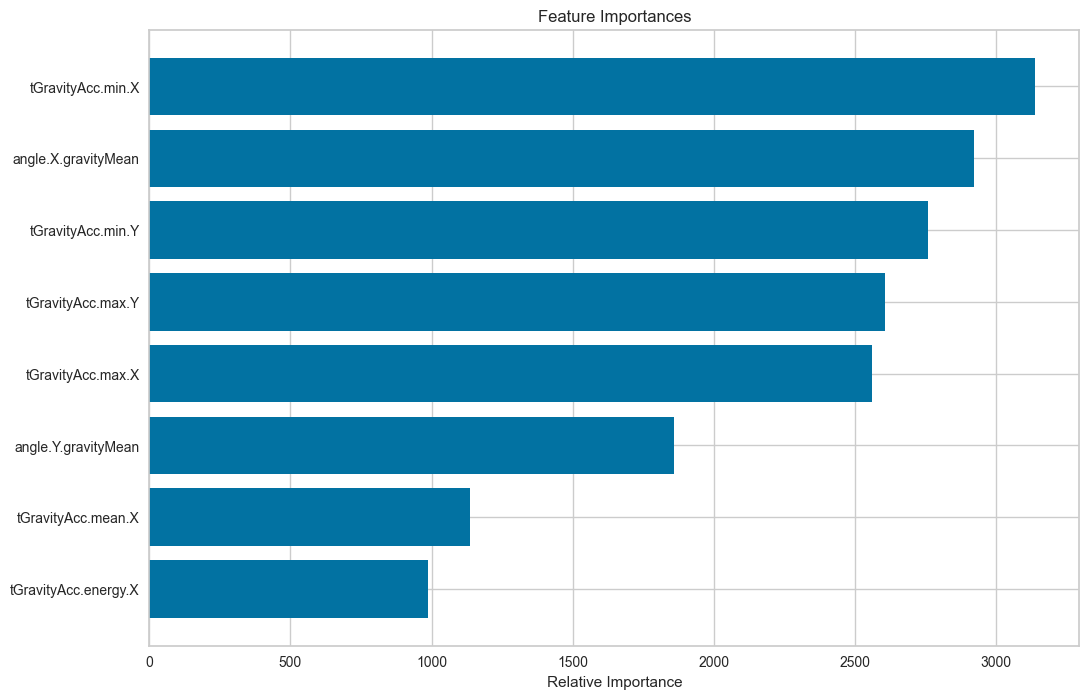

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. 특성 중요도 시각화
# feature_importances = rf_clf.feature_importances_
feature_importances = lgbm_clf.feature_importances_

indices = np.argsort(feature_importances)

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [selected_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


### Random Forest 활용

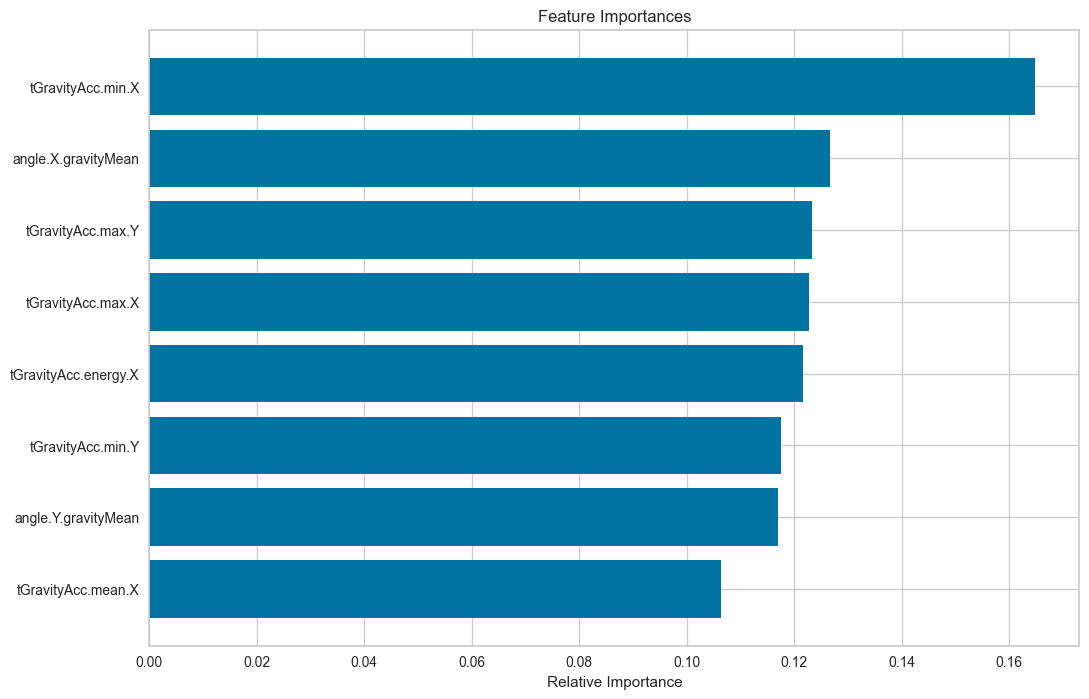

In [81]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# import numpy as np

# 1. 특성 중요도 시각화 (Random Forest)
feature_importances = rf_clf.feature_importances_
# feature_importances = lgbm_clf.feature_importances_

indices = np.argsort(feature_importances)

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [selected_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


#### 4. 시각화_혼돈행렬 (lightGBM)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1963
[LightGBM] [Info] Number of data points in the train set: 2887, number of used features: 8
[LightGBM] [Info] Start training from score -1.650808
[LightGBM] [Info] Start training from score -1.759383
[LightGBM] [Info] Start training from score -1.710306
[LightGBM] [Info] Start training from score -1.800457
[LightGBM] [Info] Start training from score -1.969037
[LightGBM] [Info] Start training from score -1.894929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


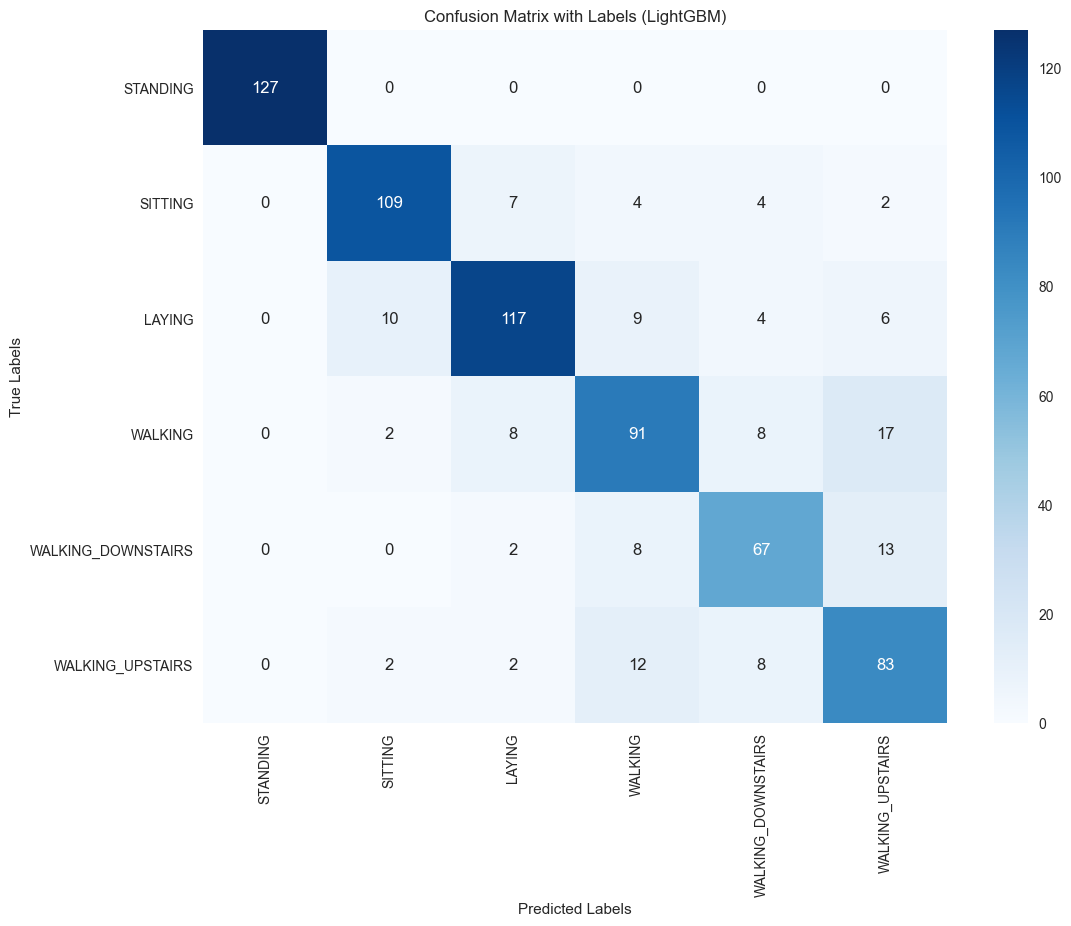

In [75]:
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# LightGBM 모델 생성 및 훈련
lgbm_clf = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_clf.fit(X_train_split[selected_features], y_train_split)

# LightGBM 모델로 예측
y_val_pred_lgbm = lgbm_clf.predict(X_val_split[selected_features])

# 혼동 행렬 생성
conf_mat_lgbm = confusion_matrix(y_val_split, y_val_pred_lgbm)

# 라벨 목록 추출
activity_labels = y_train.unique().tolist()

# 혼동 행렬 시각화
plt.figure(figsize=(12, 9))
sns.heatmap(conf_mat_lgbm, annot=True, fmt="d", cmap="Blues",
            xticklabels=activity_labels, yticklabels=activity_labels)
plt.title('Confusion Matrix with Labels (LightGBM)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


4.시각화_주요 특성 빈도

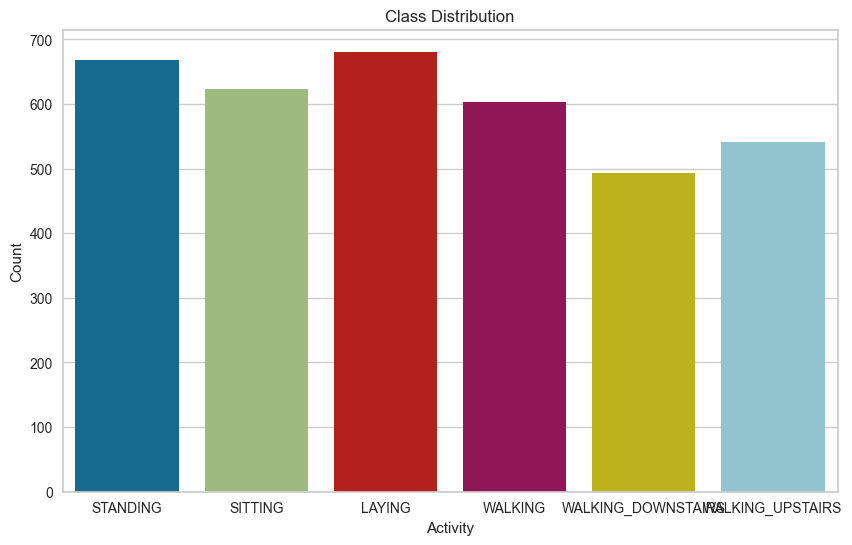

In [71]:

# 3. 클래스 별 데이터 분포
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='activity')
plt.title('Class Distribution')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.show()


##### 4.시각화_3D 특성 분포도

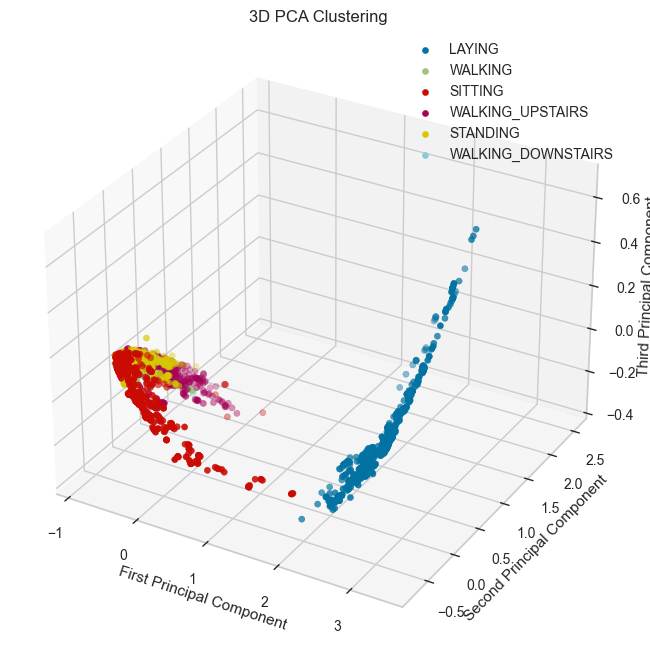

In [84]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
# 3D 시각화를 위한 PCA 차원 축소
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_train_split[selected_features])

# 3D 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 각 클래스별로 다른 색상과 레이블을 사용하여 점을 그립니다.
for label in y_train_split.unique():
    ax.scatter(X_pca_3d[y_train_split == label, 0], 
               X_pca_3d[y_train_split == label, 1], 
               X_pca_3d[y_train_split == label, 2], 
               label=label)
    
ax.set_title('3D PCA Clustering')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')
ax.legend()
plt.show()

